In [0]:
import numpy as np 
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import itertools  
import random
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Autoregressive Model 
## Generating Train data and Test data 

In [0]:
#Generate Train Data 
#X(t) = a1*X(t-1) + a2*X(t-2) + a3*X(t-3) + U(t)
train_data = []
a1 = 0.6
a2 = -0.5
a3 = -0.2
for i in range(2000):
  if i == 0:
    train_data.append(np.random.uniform(0,0.1))
  elif i == 1:
    train_data.append(a1 * train_data[0] + np.random.uniform(0,0.1))
  elif i == 2:
    train_data.append(a1 * train_data[1] + a2 * train_data[0]  + np.random.uniform(0,0.1))
  else:
    train_data.append(a1 * train_data[i-1] + a2 * train_data[i-2] + a3 * train_data[i-3] + np.random.uniform(0,0.1))
# print(train_data[:])

test_data = []

#Generate Test Data 

for i in range(2000):
  if i == 0:
    test_data.append(2 + np.random.uniform(0,0.1))
  elif i == 1:
    test_data.append(a1 * test_data[0] + np.random.uniform(0,0.1))
  elif i == 2:
    test_data.append(a1 * test_data[1] + a2 * test_data[0]  + np.random.uniform(0,0.1))
  else:
    test_data.append(a1 * test_data[i-1] + a2 * test_data[i-2] + a3 * test_data[i-3] + np.random.uniform(0,0.1))

print(type(train_data))
train_data = np.array(train_data)
print(type(train_data))
# print(train_data.shape())
b = torch.from_numpy(train_data)
print(b[:])

<class 'list'>
<class 'numpy.ndarray'>
tensor([0.0844, 0.1330, 0.1330,  ..., 0.0624, 0.0764, 0.0155],
       dtype=torch.float64)


## Transforming the data 
Breaking the sequences to a set of 3 sequences so that we have 3 RNNCells at each layer. Since, anything about this wasn't mentioned, I took the liberty to do this.  

In [0]:
# we need to transform the data into batch type so that we can input this to RNNCells. Breaking it into a sequence lengths of 3 each.

def transform_data(arr, seq_len):
    x, y = [], []
    for i in range(len(arr) - seq_len):
        x_i = arr[i : i + seq_len]
        y_i = arr[i + seq_len: i + seq_len + 1]
        x.append(np.array(x_i))
        y.append(np.array(y_i).astype('float64'))
    x_arr = np.array(x).reshape(-1, seq_len)
    y_arr = np.array(y)
    x_var = Variable(torch.from_numpy(x_arr).float())
    y_var = Variable(torch.from_numpy(y_arr).float())
    return x_var, y_var

seq_len = 3
train_input, train_target = transform_data(train_data, seq_len)
test_input, test_target = transform_data(test_data, seq_len)
print(np.shape(train_input))
print(np.shape(train_target))
print(train_input[:5])
print(np.shape(test_target))

torch.Size([1997, 3])
torch.Size([1997, 1])
tensor([[ 0.0844,  0.1330,  0.1330],
        [ 0.1330,  0.1330,  0.0316],
        [ 0.1330,  0.0316, -0.0604],
        [ 0.0316, -0.0604, -0.0217],
        [-0.0604, -0.0217,  0.0700]])
torch.Size([1997, 1])


## RNN with 1 layer 

In [0]:
class RNN_1layer(nn.Module):
    def __init__(self, input_size=1, output_size=1, num_layers=1):
        super().__init__()
        # self.hidden_layer_size = hidden_layer_size
        self.out_layer_size = output_size
        self.rnn = nn.RNN(input_size, output_size, num_layers)

        # self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(num_layers,1,self.out_layer_size))

    def forward(self, input_seq):
        rnn_out, self.hidden_cell = self.rnn(input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
        # predictions = self.linear(lstm_out.view(len(input_seq), -1))
        predictions = rnn_out.view(len(input_seq), -1)
        return predictions[-1]

We choose 3 things here:
- Learning rate: $2*10^{-6}$
- Optmiser: Stochastic Gradient Descent 
- Loss function: MSE loss 

In [0]:
model = RNN_1layer()
loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=2*10e-6)
print(model)

RNN_1layer(
  (rnn): RNN(1, 1)
)


### RNN with 1 Layer Training 

We plot the epoch vs loss curve of the model during training 

epoch:   1 loss: 0.24440557
epoch:   3 loss: 0.19679061
epoch:   5 loss: 0.15621440
epoch:   7 loss: 0.12234732
epoch:   9 loss: 0.09467743
epoch:  11 loss: 0.07254701
epoch:  13 loss: 0.05519594
epoch:  15 loss: 0.04182401
epoch:  17 loss: 0.03166018
epoch:  19 loss: 0.02401299
epoch:  21 loss: 0.01829773
epoch:  23 loss: 0.01404172
epoch:  25 loss: 0.01087554
epoch:  27 loss: 0.00851717
epoch:  29 loss: 0.00675526
epoch:  31 loss: 0.00543311
epoch:  33 loss: 0.00443543
epoch:  35 loss: 0.00367783
epoch:  37 loss: 0.00309849
epoch:  39 loss: 0.00265231
epoch:  41 loss: 0.00230618
epoch:  43 loss: 0.00203566
epoch:  45 loss: 0.00182285
epoch:  47 loss: 0.00165426
epoch:  49 loss: 0.00151991


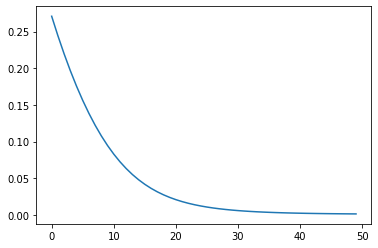

In [0]:
epochs = 50
loss_epoch = []
index = []
for i in range(epochs):
    # y = 0
    index.append(i)
    for seq, labels in itertools.zip_longest(train_input, train_target):
        # print(np.shape(seq))
        # print(y+1)
        # y = y + 1
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.out_layer_size))
        # print(np.shape(seq))
        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()
    loss_epoch.append(single_loss.item())
    if i%2 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')
plt.plot(index, loss_epoch)

### RNN with 1 layer Testing 

MAE, MSE, R2 score on test data is mentioned below. 

In [0]:
model.eval()
test_outputs = []
for seq in test_input:
  # print(np.shape(seq))
  with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.out_layer_size))
        test_outputs.append(model(seq).item())

test_outputs=np.array(test_outputs)
test_outputs=Variable(torch.from_numpy(test_outputs).float())
MSE_loss = loss_function(test_outputs, test_target)
L1_loss_function = nn.L1Loss()
MAE_loss = L1_loss_function(test_outputs, test_target)
R2 = r2_score(test_target,test_outputs) 
print("MSE loss", MSE_loss.item())
print("MAE loss", MAE_loss.item())
print("R2 score", R2)

MSE loss 2.6120080947875977
MAE loss 1.358898639678955
R2 score 0.0074446140994558485


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([1994, 1])) that is different to the input size (torch.Size([1994])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:88: UserWarning: Using a target size (torch.Size([1994, 1])) that is different to the input size (torch.Size([1994])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


## 2 layers of RNNs 

In [0]:
class RNN_2layer(nn.Module):
    def __init__(self, input_size=1, output_size=1, num_layers=2):
        super().__init__()
        # self.hidden_layer_size = hidden_layer_size
        self.out_layer_size = output_size
        self.rnn = nn.RNN(input_size, output_size, num_layers)

        # self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(num_layers,1,self.out_layer_size))

    def forward(self, input_seq):
        rnn_out, self.hidden_cell = self.rnn(input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
        # predictions = self.linear(lstm_out.view(len(input_seq), -1))
        predictions = rnn_out.view(len(input_seq), -1)
        return predictions[-1]



We choose 3 things here:
- Learning rate: $10^{-6}$
- Optmiser: Stochastic Gradient Descent 
- Loss function: MSE loss 


In [0]:
model = RNN_2layer()
loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=10e-6)
print(model)

RNN_2layer(
  (rnn): RNN(1, 1, num_layers=2)
)


### 2 Layer RNN Model Training 
We plot epoch vs loss curve during training of this model 

epoch:   1 loss: 3.78219986
epoch:   3 loss: 3.78218627
epoch:   5 loss: 3.78217244
epoch:   7 loss: 3.78215861
epoch:   9 loss: 3.78214550
epoch:  11 loss: 3.78213167
epoch:  13 loss: 3.78211832
epoch:  15 loss: 3.78210473
epoch:  17 loss: 3.78209186
epoch:  19 loss: 3.78207779
epoch:  21 loss: 3.78206491
epoch:  23 loss: 3.78205109
epoch:  25 loss: 3.78203797
epoch:  27 loss: 3.78202415
epoch:  29 loss: 3.78201103
epoch:  31 loss: 3.78199768
epoch:  33 loss: 3.78198457
epoch:  35 loss: 3.78197122
epoch:  37 loss: 3.78195834
epoch:  39 loss: 3.78194523
epoch:  41 loss: 3.78193283
epoch:  43 loss: 3.78191972
epoch:  45 loss: 3.78190732
epoch:  47 loss: 3.78189421
epoch:  49 loss: 3.78188181


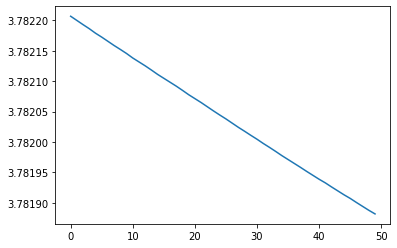

In [0]:
epochs = 50
loss_epoch = []
index = []
for i in range(epochs):
    # y = 0
    index.append(i)
    for seq, labels in itertools.zip_longest(train_input, train_target):
        # print(np.shape(seq))
        # print(y+1)
        # y = y + 1
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(2, 1, model.out_layer_size))
        # print(np.shape(seq))
        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    loss_epoch.append(single_loss.item())
    if i%2 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

# print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')
plt.plot(index, loss_epoch)

### 2 layer RNN model on Test Data 

In [0]:
model.eval()
test_outputs = []
for seq in test_input:
  # print(np.shape(seq))
  with torch.no_grad():
        model.hidden = (torch.zeros(2, 1, model.out_layer_size))
        test_outputs.append(model(seq).item())

MSE, MAE, R2 scores of this model on the test data are mentioned below. 

In [0]:
test_outputs=np.array(test_outputs)
test_outputs=Variable(torch.from_numpy(test_outputs).float())
MSE_loss = loss_function(test_outputs, test_target)
L1_loss_function = nn.L1Loss()
MAE_loss = L1_loss_function(test_outputs, test_target)
R2 = r2_score(test_target,test_outputs) 
print("MSE loss", MSE_loss.item())
print("MAE loss", MAE_loss.item())
print("R2 score", R2)

MSE loss 2.557121992111206
MAE loss 1.3469280004501343
R2 score 0.0006081058351787849


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([1994, 1])) that is different to the input size (torch.Size([1994])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:88: UserWarning: Using a target size (torch.Size([1994, 1])) that is different to the input size (torch.Size([1994])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


## 3 layers of RNN 

In [0]:
class RNN_3layer(nn.Module):
    def __init__(self, input_size=1, output_size=1, num_layers=3):
        super().__init__()
        # self.hidden_layer_size = hidden_layer_size
        self.out_layer_size = output_size
        self.rnn = nn.RNN(input_size, output_size, num_layers)

        # self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(num_layers,1,self.out_layer_size))

    def forward(self, input_seq):
        rnn_out, self.hidden_cell = self.rnn(input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
        # predictions = self.linear(lstm_out.view(len(input_seq), -1))
        predictions = rnn_out.view(len(input_seq), -1)
        return predictions[-1]


We choose 3 things here:
- Learning rate: $5*10^{-5}$
- Optmiser: Stochastic Gradient Descent 
- Loss function: MSE loss 


In [0]:
model = RNN_3layer()
loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=5*10e-5)
print(model)

RNN_3layer(
  (rnn): RNN(1, 1, num_layers=3)
)


### Training of this Model 
- We choose to run this model for 50 epochs 
- Plot learning rate vs epochs on the training data 

epoch:   1 loss: 0.00045801
epoch:   3 loss: 0.00044342
epoch:   5 loss: 0.00044282
epoch:   7 loss: 0.00044227
epoch:   9 loss: 0.00044170
epoch:  11 loss: 0.00044113
epoch:  13 loss: 0.00044056
epoch:  15 loss: 0.00043998
epoch:  17 loss: 0.00043937
epoch:  19 loss: 0.00043880
epoch:  21 loss: 0.00043823
epoch:  23 loss: 0.00043766
epoch:  25 loss: 0.00043709
epoch:  27 loss: 0.00043650
epoch:  29 loss: 0.00043590
epoch:  31 loss: 0.00043531
epoch:  33 loss: 0.00043469
epoch:  35 loss: 0.00043411
epoch:  37 loss: 0.00043354
epoch:  39 loss: 0.00043291
epoch:  41 loss: 0.00043230
epoch:  43 loss: 0.00043172
epoch:  45 loss: 0.00043110
epoch:  47 loss: 0.00043048
epoch:  49 loss: 0.00042986


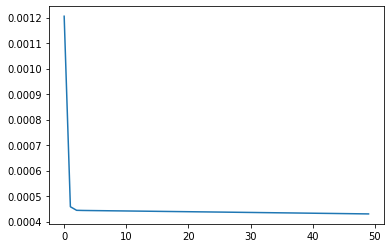

In [0]:
epochs = 50
loss_epoch = []
index = []
for i in range(epochs):
    # y = 0
    index.append(i)
    for seq, labels in itertools.zip_longest(train_input, train_target):
        # print(np.shape(seq))
        # print(y+1)
        # y = y + 1
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(3, 1, model.out_layer_size))
        # print(np.shape(seq))
        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    loss_epoch.append(single_loss.item())
    if i%2 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

# print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')
plt.plot(index, loss_epoch)

### Testing this Model 
We plot mention MSE, MAE and R2 scores below 

In [0]:
model.eval()
test_outputs = []
for seq in test_input:
  # print(np.shape(seq))
  with torch.no_grad():
        model.hidden = (torch.zeros(3, 1, model.out_layer_size))
        test_outputs.append(model(seq).item())

In [0]:
test_outputs=np.array(test_outputs)
test_outputs=Variable(torch.from_numpy(test_outputs).float())
MSE_loss = loss_function(test_outputs, test_target)
L1_loss_function = nn.L1Loss()
MAE_loss = L1_loss_function(test_outputs, test_target)
R2 = r2_score(test_target,test_outputs) 
print("MSE loss", MSE_loss.item())
print("MAE loss", MAE_loss.item())
print("R2 score", R2)

MSE loss 0.004309444222599268
MAE loss 0.043261315673589706
R2 score -0.1973995598451206


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([1997, 1])) that is different to the input size (torch.Size([1997])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:88: UserWarning: Using a target size (torch.Size([1997, 1])) that is different to the input size (torch.Size([1997])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


All the models converge but RNN with 3 layers performs the best. It has the least MSE and MAE scores on the test data. 

# Moving Average Model 

## Generate Train Data and Test Data 

In [0]:
train_data = []
slide_block = []
a1 = 5
a2 = -1
a3 = -1
a4 = -1
a5 = -1 
for i in range(2000):
  if i == 0:
    slide_block.append(np.random.uniform(0,1))
    train_data.append(slide_block[i])
  elif i == 1:
    slide_block.append(np.random.uniform(0,1))
    train_data.append(a1 * slide_block[i-1] + slide_block[i])
  elif i == 2:
    slide_block.append(np.random.uniform(0,1))
    train_data.append(a2 * slide_block[i-2] + a1 * slide_block[i-1] + slide_block[i])
  elif i == 3:
    slide_block.append(np.random.uniform(0,1))
    train_data.append(a3 * slide_block[i-3] + a2 * slide_block[i-2] + a1 * slide_block[i-1] + slide_block[i])
  elif i == 4:
    slide_block.append(np.random.uniform(0,1))
    train_data.append(a4 * slide_block[i-4] + a3 * slide_block[i-3] + a2 * slide_block[i-2] + a1 * slide_block[i-1] + slide_block[i])
  else:
    slide_block.append(np.random.uniform(0,1))
    train_data.append(a5 * slide_block[i-5] + a4 * slide_block[i-4] + a3 * slide_block[i-3] + a2 * slide_block[i-2] + a1 * slide_block[i-1] + slide_block[i])

slide_block = []
test_data = []
for i in range(2000):
  if i == 0:
    slide_block.append(np.random.uniform(0,1))
    test_data.append(slide_block[i])
  elif i == 1:
    slide_block.append(np.random.uniform(0,1))
    test_data.append(a1 * slide_block[i-1] + slide_block[i])
  elif i == 2:
    slide_block.append(np.random.uniform(0,1))
    test_data.append(a2 * slide_block[i-2] + a1 * slide_block[i-1] + slide_block[i])
  elif i == 3:
    slide_block.append(np.random.uniform(0,1))
    test_data.append(a3 * slide_block[i-3] + a2 * slide_block[i-2] + a1 * slide_block[i-1] + slide_block[i])
  elif i == 4:
    slide_block.append(np.random.uniform(0,1))
    test_data.append(a4 * slide_block[i-4] + a3 * slide_block[i-3] + a2 * slide_block[i-2] + a1 * slide_block[i-1] + slide_block[i])
  else:
    slide_block.append(np.random.uniform(0,1))
    test_data.append(a5 * slide_block[i-5] + a4 * slide_block[i-4] + a3 * slide_block[i-3] + a2 * slide_block[i-2] + a1 * slide_block[i-1] + slide_block[i])

## Transform the Data
We do this so as to make a set containing 6 sequence of numbers each. This makes sure that at each layer we have 6 RNN Cells (at one time step)  

In [0]:
def transform_data(arr, seq_len):
    x, y = [], []
    for i in range(len(arr) - seq_len):
        x_i = arr[i : i + seq_len]
        y_i = arr[i + seq_len: i + seq_len + 1]
        x.append(np.array(x_i))
        y.append(np.array(y_i).astype('float64'))
    x_arr = np.array(x).reshape(-1, seq_len)
    y_arr = np.array(y)
    x_var = Variable(torch.from_numpy(x_arr).float())
    y_var = Variable(torch.from_numpy(y_arr).float())
    return x_var, y_var

seq_len = 6
train_input, train_target = transform_data(train_data, seq_len)
test_input, test_target = transform_data(test_data, seq_len)
print(np.shape(train_input))
print(np.shape(train_target))
print(train_input[:5])
print(np.shape(test_target))

torch.Size([1994, 6])
torch.Size([1994, 1])
tensor([[ 0.6131,  3.7148,  2.8508,  0.1590,  0.4988,  0.1819],
        [ 3.7148,  2.8508,  0.1590,  0.4988,  0.1819,  1.2940],
        [ 2.8508,  0.1590,  0.4988,  0.1819,  1.2940, -0.9703],
        [ 0.1590,  0.4988,  0.1819,  1.2940, -0.9703,  0.5317],
        [ 0.4988,  0.1819,  1.2940, -0.9703,  0.5317,  2.4398]])
torch.Size([1994, 1])


## 1 layer RNN network 

In [0]:
class RNN_1layer_Q2(nn.Module):
    def __init__(self, input_size=1, output_size=1, num_layers=1):
        super().__init__()
        # self.hidden_layer_size = hidden_layer_size
        self.out_layer_size = output_size
        self.rnn = nn.RNN(input_size, output_size, num_layers)

        # self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(num_layers,1,self.out_layer_size))

    def forward(self, input_seq):
        rnn_out, self.hidden_cell = self.rnn(input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
        # predictions = self.linear(lstm_out.view(len(input_seq), -1))
        predictions = rnn_out.view(len(input_seq), -1)
        return predictions[-1]


We choose 3 things here:
- Learning rate: $10^{-6}$
- Optmiser: Stochastic Gradient Descent 
- Loss function: MSE loss


In [0]:
model = RNN_1layer_Q2()
loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=10e-6)
print(model)

RNN_1layer_Q2(
  (rnn): RNN(1, 1)
)


### 1 Layer RNN Training
We plot the epoch vs loss of the model on the training data. 

epoch:   1 loss: 5.06079340
epoch:   3 loss: 4.20561981
epoch:   5 loss: 3.45713806
epoch:   7 loss: 2.85849738
epoch:   9 loss: 2.39513516
epoch:  11 loss: 2.00501108
epoch:  13 loss: 1.73391354
epoch:  15 loss: 1.65428352
epoch:  17 loss: 1.62343299
epoch:  19 loss: 1.60579765
epoch:  21 loss: 1.59383357
epoch:  23 loss: 1.58495390
epoch:  25 loss: 1.57800233
epoch:  27 loss: 1.57236338
epoch:  29 loss: 1.56767440
epoch:  31 loss: 1.56370604
epoch:  33 loss: 1.56030130
epoch:  35 loss: 1.55735505
epoch:  37 loss: 1.55478036
epoch:  39 loss: 1.55251908
epoch:  41 loss: 1.55052733
epoch:  43 loss: 1.54876494
epoch:  45 loss: 1.54720557
epoch:  47 loss: 1.54582441
epoch:  49 loss: 1.54459989


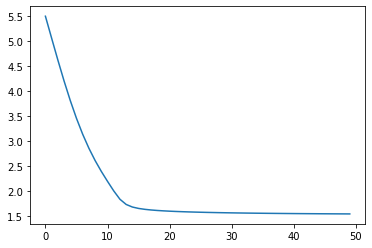

In [0]:
epochs = 50
loss_epoch = []
index = []
for i in range(epochs):
    index.append(i)
    for seq, labels in itertools.zip_longest(train_input, train_target):
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.out_layer_size))
        # print(np.shape(seq))
        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()
    loss_epoch.append(single_loss.item())
    if i%2 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')
plt.plot(index, loss_epoch)

### 1 Layer RNN Model Testing 

In [0]:
model.eval()
test_outputs = []
for seq in test_input:
  with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.out_layer_size))
        test_outputs.append(model(seq).item())

We mention the MSE, MAE and the R2 scores of the model on the test below.

In [0]:
test_outputs=np.array(test_outputs)
test_outputs=Variable(torch.from_numpy(test_outputs).float())
MSE_loss = loss_function(test_outputs, test_target)
L1_loss_function = nn.L1Loss()
MAE_loss = L1_loss_function(test_outputs, test_target)
R2 = r2_score(test_target,test_outputs) 
print("MSE loss", MSE_loss.item())
print("MAE loss", MAE_loss.item())
print("R2 score", R2)

MSE loss 2.438246011734009
MAE loss 1.3089390993118286
R2 score -0.004733755374010995


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([1994, 1])) that is different to the input size (torch.Size([1994])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:88: UserWarning: Using a target size (torch.Size([1994, 1])) that is different to the input size (torch.Size([1994])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


## 2 layer RNN network 

In [0]:
class RNN_2layer_Q2(nn.Module):
    def __init__(self, input_size=1, output_size=1, num_layers=2):
        super().__init__()
        # self.hidden_layer_size = hidden_layer_size
        self.out_layer_size = output_size
        self.rnn = nn.RNN(input_size, output_size, num_layers)

        # self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(num_layers,1,self.out_layer_size))

    def forward(self, input_seq):
        rnn_out, self.hidden_cell = self.rnn(input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
        # predictions = self.linear(lstm_out.view(len(input_seq), -1))
        predictions = rnn_out.view(len(input_seq), -1)
        return predictions[-1]


We choose 3 things here:
- Learning rate: $5*10^{-8}$
- Optmiser: Stochastic Gradient Descent 
- Loss function: MSE loss 


In [0]:
model = RNN_2layer_Q2()
loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=5*10e-8)
print(model)

RNN_2layer_Q2(
  (rnn): RNN(1, 1, num_layers=2)
)


### 2 layer RNN network Training 

We plot epoch vs loss of the model on train data 

epoch:   1 loss: 1.16984010
epoch:   3 loss: 1.15793598
epoch:   5 loss: 1.14601696
epoch:   7 loss: 1.13408494
epoch:   9 loss: 1.12214541
epoch:  11 loss: 1.11020327
epoch:  13 loss: 1.09825873
epoch:  15 loss: 1.08631516
epoch:  17 loss: 1.07437837
epoch:  19 loss: 1.06245148
epoch:  21 loss: 1.05053580
epoch:  23 loss: 1.03863668
epoch:  25 loss: 1.02675939
epoch:  27 loss: 1.01490283
epoch:  29 loss: 1.00307274
epoch:  31 loss: 0.99127227
epoch:  33 loss: 0.97950250
epoch:  35 loss: 0.96776921
epoch:  37 loss: 0.95607466
epoch:  39 loss: 0.94442254
epoch:  41 loss: 0.93281591
epoch:  43 loss: 0.92125589
epoch:  45 loss: 0.90974599
epoch:  47 loss: 0.89828777
epoch:  49 loss: 0.88688588


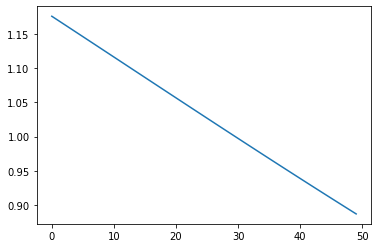

In [0]:
epochs = 50
loss_epoch = []
index = []
for i in range(epochs):
    index.append(i)
    for seq, labels in itertools.zip_longest(train_input, train_target):
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(2, 1, model.out_layer_size))
        # print(np.shape(seq))
        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()
    loss_epoch.append(single_loss.item())
    if i%2 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')
plt.plot(index, loss_epoch)

### Testing the Model 

In [0]:
model.eval()
test_outputs = []
for seq in test_input:
  with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.out_layer_size))
        test_outputs.append(model(seq).item())

MSE, MAE and R2 scores of the model on the testing data are reported below 

In [0]:
test_outputs=np.array(test_outputs)
test_outputs=Variable(torch.from_numpy(test_outputs).float())
MSE_loss = loss_function(test_outputs, test_target)
L1_loss_function = nn.L1Loss()
MAE_loss = L1_loss_function(test_outputs, test_target)
R2 = r2_score(test_target,test_outputs) 
print("MSE loss", MSE_loss.item())
print("MAE loss", MAE_loss.item())
print("R2 score", R2)

MSE loss 4.50956392288208
MAE loss 1.7342060804367065
R2 score -0.828726858630068


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([1994, 1])) that is different to the input size (torch.Size([1994])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:88: UserWarning: Using a target size (torch.Size([1994, 1])) that is different to the input size (torch.Size([1994])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


## 3 Layer RNN Network 

In [0]:
class RNN_3layer_Q2(nn.Module):
    def __init__(self, input_size=1, output_size=1, num_layers=3):
        super().__init__()
        # self.hidden_layer_size = hidden_layer_size
        self.out_layer_size = output_size
        self.rnn = nn.RNN(input_size, output_size, num_layers)

        # self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(num_layers,1,self.out_layer_size))

    def forward(self, input_seq):
        rnn_out, self.hidden_cell = self.rnn(input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
        # predictions = self.linear(lstm_out.view(len(input_seq), -1))
        predictions = rnn_out.view(len(input_seq), -1)
        return predictions[-1]


We choose 3 things here:
- Learning rate: $5*10^{-8}$
- Optmiser: Stochastic Gradient Descent 
- Loss function: MSE loss 


In [0]:
model = RNN_3layer_Q2()
loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=5*10e-8)
print(model)

RNN_3layer_Q2(
  (rnn): RNN(1, 1, num_layers=3)
)


### Training the Model 
We run it for 50 epochs. We plot the epoch vs loss of the model on the training data 

epoch:   1 loss: 0.17960979
epoch:   3 loss: 0.17582397
epoch:   5 loss: 0.17208840
epoch:   7 loss: 0.16840407
epoch:   9 loss: 0.16477112
epoch:  11 loss: 0.16118963
epoch:  13 loss: 0.15766247
epoch:  15 loss: 0.15418713
epoch:  17 loss: 0.15076259
epoch:  19 loss: 0.14738831
epoch:  21 loss: 0.14406525
epoch:  23 loss: 0.14079344
epoch:  25 loss: 0.13757378
epoch:  27 loss: 0.13440447
epoch:  29 loss: 0.13128607
epoch:  31 loss: 0.12821686
epoch:  33 loss: 0.12519871
epoch:  35 loss: 0.12223171
epoch:  37 loss: 0.11931436
epoch:  39 loss: 0.11644662
epoch:  41 loss: 0.11362819
epoch:  43 loss: 0.11086078
epoch:  45 loss: 0.10814177
epoch:  47 loss: 0.10546942
epoch:  49 loss: 0.10284472


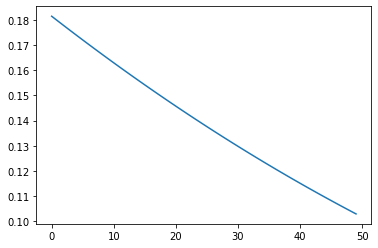

In [0]:
epochs = 50
loss_epoch = []
index = []
for i in range(epochs):
    index.append(i)
    for seq, labels in itertools.zip_longest(train_input, train_target):
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(3, 1, model.out_layer_size))
        # print(np.shape(seq))
        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()
    loss_epoch.append(single_loss.item())
    if i%2 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')
plt.plot(index, loss_epoch)

### Testing the Model

In [0]:
model.eval()
test_outputs = []
for seq in test_input:
  with torch.no_grad():
        model.hidden = (torch.zeros(3, 1, model.out_layer_size))
        test_outputs.append(model(seq).item())

We report MSE, MAE and R2 scores of the model on the testing data below 

In [0]:
test_outputs=np.array(test_outputs)
test_outputs=Variable(torch.from_numpy(test_outputs).float())
MSE_loss = loss_function(test_outputs, test_target)
L1_loss_function = nn.L1Loss()
MAE_loss = L1_loss_function(test_outputs, test_target)
R2 = r2_score(test_target,test_outputs) 
print("MSE loss", MSE_loss.item())
print("MAE loss", MAE_loss.item())
print("R2 score", R2)

MSE loss 3.0029566287994385
MAE loss 1.4371296167373657
R2 score -0.21807303965048153


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([1994, 1])) that is different to the input size (torch.Size([1994])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:88: UserWarning: Using a target size (torch.Size([1994, 1])) that is different to the input size (torch.Size([1994])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Here, 1 layer RNN performs the best with least MSE and MAE scores on the test data. Probably because the other models overtrain on the training data leading to their bad performance. Nonetheless, all models converge while training. 